# Setup

In [1]:
# load libraries
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# control the figure size
plt.rcParams["figure.figsize"] = (20,3)


In [2]:
# load demand data
demand_data = pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/demand.csv',
    dtype={"Month": str, "Date": int, "Demand": int})

# load intake price data
intake_price_data =  pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/intake_price.csv',
    dtype={"Intake": int, "Price": float})

In [4]:
# inspect demand data
demand_data.head()

,Month,Date,Demand
0,December,1,94
1,December,2,304
2,December,3,70
3,December,4,222
4,December,5,123


In [5]:
# inspect intake price data
intake_price_data.head()

,Intake,Price
0,20,1.0
1,24,1.0
2,31,1.0
3,34,1.0
4,37,1.0


# Decision Variables

In [6]:
# decision variables
calng_price = 7.50 # set by CaLNG

peak_intake_from_pipeline = 181

# Utility (Actual Usage)

In [7]:
def determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, total_lng_intake):
    '''
    this function determines the actual usage given CaLNG's price and peak intake from pipeline

    inputs:
    - calng_price: price set by CaLNG
    - peak_intake_from_pipeline: maximum intake from pipeline, after which consume LNG
    - demand_data: observed demand data (Month, Data, Demand in MMcF)
    - total_lng_intake: maximum amount ogf LNG to be used over the season

    outputs:
    - usage_data: usage data given observed demand, CaLNG price, and peak intake from pipeline
    '''
    usage_data = demand_data.copy()

    # set price index
    usage_data.reset_index(inplace=True, drop=False)
    usage_data = usage_data.rename(columns={'index': 'price_index'})

    usage_data['pipeline_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['Demand'] - 144)/60)), axis=1)
    usage_data['cost_from_pipeline_only'] = usage_data['Demand'] * usage_data['pipeline_price']
    usage_data['demand_for_lng'] = usage_data.apply(lambda row: max(row['Demand'] - peak_intake_from_pipeline, 0), axis=1)
    usage_data['purchase_from_calng'] = 0

    accumulated_lng_usage = 0

    for index, row in usage_data.iterrows():
        purchase =  min(row['demand_for_lng'], total_lng_intake - accumulated_lng_usage)
        usage_data.loc[index, 'purchase_from_calng'] = purchase
        accumulated_lng_usage = accumulated_lng_usage + purchase


    usage_data['pipeline_intake'] = usage_data['Demand']-usage_data['purchase_from_calng']
    usage_data['pipeline_intake_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['pipeline_intake'] - 144)/60)), axis=1)
    usage_data['cost_from_both'] = usage_data['pipeline_intake'] * usage_data['pipeline_intake_price'] + usage_data['purchase_from_calng'] * calng_price
    usage_data['savings'] = usage_data['cost_from_pipeline_only'] - usage_data['cost_from_both']

    return usage_data


In [8]:
# get usage data
usage_data = determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, 1288)

# inspect usage_data (round to 2 decimal places)
np.round(usage_data,2)

,price_index,Month,Date,Demand,pipeline_price,cost_from_pipeline_only,demand_for_lng,purchase_from_calng,pipeline_intake,pipeline_intake_price,cost_from_both,savings
0,0,December,1,94,1.00,94.00,0,0,94,1.00,94.00,0.00
1,1,December,2,304,14.39,4375.14,123,123,181,1.85,1257.85,3117.30
2,2,December,3,70,1.00,70.00,0,0,70,1.00,70.00,0.00
3,3,December,4,222,3.67,814.58,41,41,181,1.85,642.85,171.74
4,4,December,5,123,1.00,123.00,0,0,123,1.00,123.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
86,86,February,25,52,1.00,52.00,0,0,52,1.00,52.00,0.00
87,87,February,26,39,1.00,39.00,0,0,39,1.00,39.00,0.00
88,88,February,27,109,1.00,109.00,0,0,109,1.00,109.00,0.00
89,89,February,28,250,5.85,1462.83,69,69,181,1.85,852.85,609.98


In [9]:
import matplotlib.pyplot as plt



# Constants
calng_price = 7.50
num_draws = 5000
total_lng_range = range(700, 1300, 50)
peak_intake_range = range(170, 200, 5)

# Simulation function to estimate cost for given parameters
def simulate_cost(total_LNG, peak_intake, demand_data, calng_price, num_draws):
    costs = []
    for _ in range(num_draws):
        # Placeholder for the simulation logic to generate demand sample
        # and determine the cost based on the `determine_actual_usage` logic
        
        # Simulated demand data should be generated here based on your assumptions or actual data
        
        # Calculate cost for the simulated demand
        usage_data = determine_actual_usage(demand_data, calng_price, peak_intake, total_LNG)
        total_cost = usage_data['cost_from_both'].sum() # Assuming 'cost_from_both' is the total cost
        costs.append(total_cost)
        
    return np.mean(costs), np.std(costs)

# Optimization process
costs_dict = {}
for total_LNG in total_lng_range:
    for peak_intake in peak_intake_range:
        avg_cost, _ = simulate_cost(total_LNG, peak_intake, demand_data, calng_price, num_draws)
        costs_dict[(total_LNG, peak_intake)] = avg_cost

# Find the optimal combination
optimal_combination = min(costs_dict, key=costs_dict.get)
optimal_total_LNG, optimal_peak_intake = optimal_combination

print(f"Optimal total_LNG: {optimal_total_LNG}, Optimal peak_intake_from_pipeline: {optimal_peak_intake}")


Optimal total_LNG: 1200, Optimal peak_intake_from_pipeline: 185


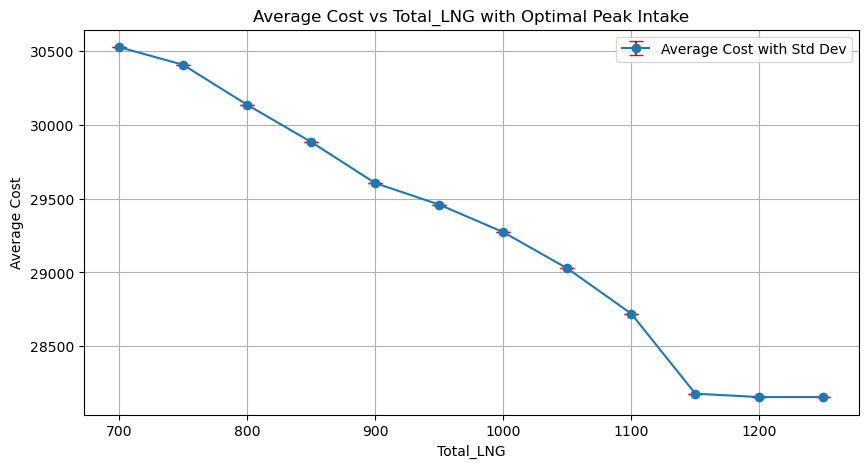

In [10]:
# Generate data for plotting: Varying total_LNG at optimal peak_intake
total_lng_costs = []
total_lng_stds = []
for total_LNG in total_lng_range:
    avg_cost, std_dev = simulate_cost(total_LNG, optimal_peak_intake, demand_data, calng_price, num_draws)
    total_lng_costs.append(avg_cost)
    total_lng_stds.append(std_dev)

# Plotting
plt.figure(figsize=(10, 5))
plt.errorbar(total_lng_range, total_lng_costs, yerr=total_lng_stds, fmt='-o', ecolor='r', capsize=5, label='Average Cost with Std Dev')
plt.title('Average Cost vs Total_LNG with Optimal Peak Intake')
plt.xlabel('Total_LNG')
plt.ylabel('Average Cost')
plt.legend()
plt.grid(True)
plt.show()

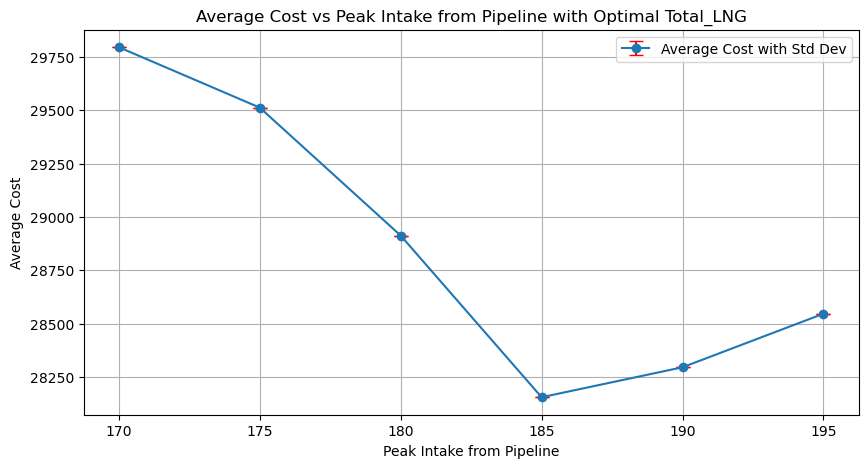

In [11]:
# Generate data for plotting: Varying peak_intake_from_pipeline at optimal total_LNG
peak_intake_costs = []
peak_intake_stds = []
for peak_intake in peak_intake_range:
    avg_cost, std_dev = simulate_cost(optimal_total_LNG, peak_intake, demand_data, calng_price, num_draws)
    peak_intake_costs.append(avg_cost)
    peak_intake_stds.append(std_dev)

# Plotting
plt.figure(figsize=(10, 5))
plt.errorbar(peak_intake_range, peak_intake_costs, yerr=peak_intake_stds, fmt='-o', ecolor='r', capsize=5, label='Average Cost with Std Dev')
plt.title('Average Cost vs Peak Intake from Pipeline with Optimal Total_LNG')
plt.xlabel('Peak Intake from Pipeline')
plt.ylabel('Average Cost')
plt.legend()
plt.grid(True)
plt.show()
